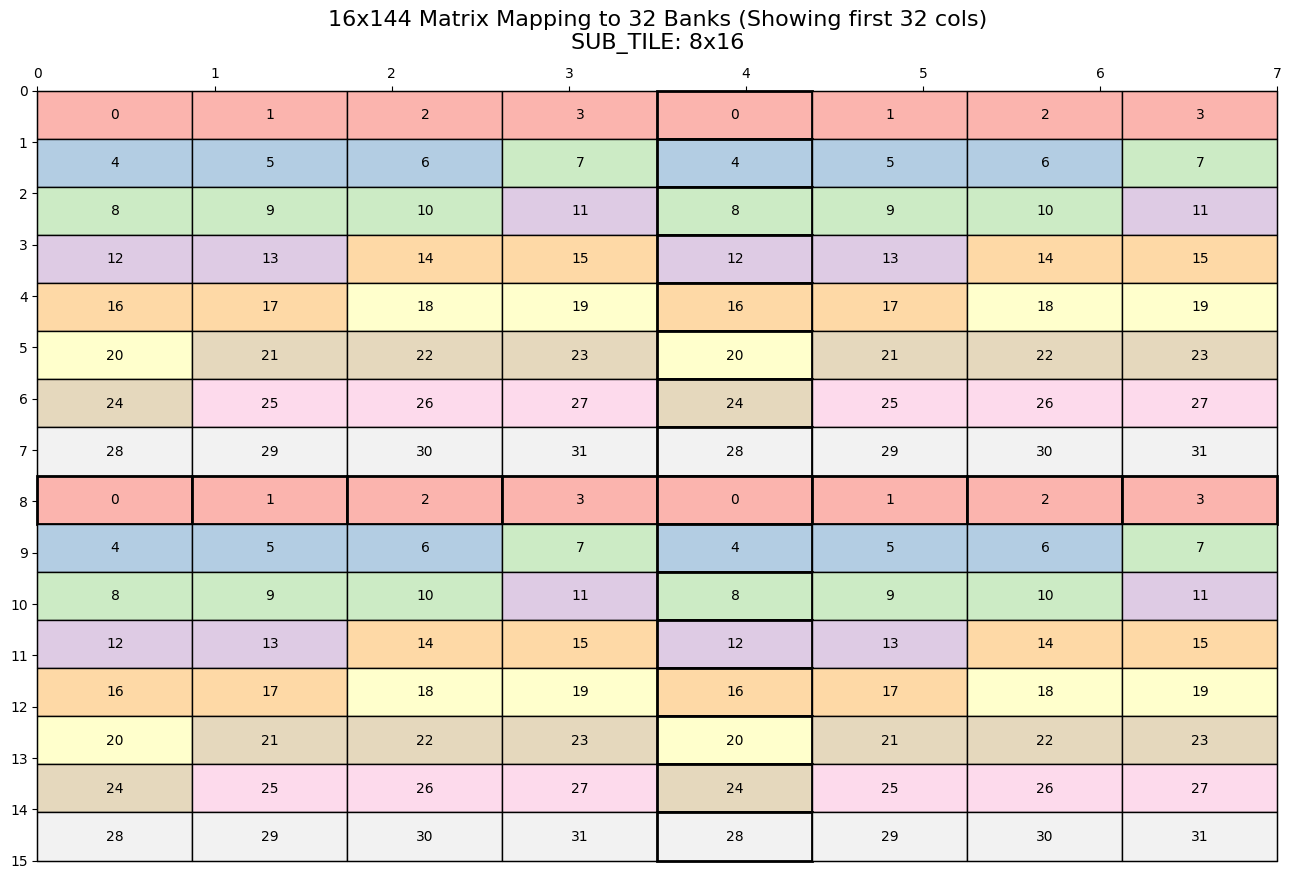

Total Banks: 32
Max Accesses per Bank: 18
Total Accesses: 576


In [26]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# --- 硬件配置更新 ---
SRAM_BANKS = 32       # 硬件Bank数量从128改为32
BYTES_PER_BANK = 4    # 每个Bank访问粒度4字节 (总带宽 32*4=128B/cycle)
SUB_TILE_H = 8        # Sub-tile 高度改为 8
SUB_TILE_W = 16       # Sub-tile 宽度改为 16

def get_bank_counts(current_counts, req_tiles, tile_rows, tile_cols, global_width, elem_size, return_addr_map=False):
        # 整个大矩阵在行方向上有多少个subtile
        subtile_per_row = (global_width + SUB_TILE_W - 1) // SUB_TILE_W 
        # 一个sub-tile的大小：8*16*1Byte = 128 Bytes (正好等于 32 Bank * 4B/bank)
        bytes_per_subtile = SUB_TILE_H * SUB_TILE_W * elem_size
        
        addr_map = {}

        for (r_idx, c_idx) in req_tiles:
            r_start = r_idx * tile_rows
            c_start = c_idx * tile_cols
            
            for r in range(tile_rows):
                global_r = r_start + r
                blk_r = global_r // SUB_TILE_H 
                off_r = global_r % SUB_TILE_H 
                
                row_subtile_base_addr = blk_r * subtile_per_row * bytes_per_subtile
                
                # 硬件访存步长 (4字节)
                step_elems = BYTES_PER_BANK // elem_size if elem_size < BYTES_PER_BANK else 1
                
                for c in range(0, tile_cols, step_elems):
                    global_c = c_start + c
                    blk_c = global_c // SUB_TILE_W 
                    off_c = global_c % SUB_TILE_W  
                    
                    # 块内偏移
                    offset_in_blk = (off_r * SUB_TILE_W + off_c) * elem_size
                    # 块基地址
                    blk_addr = row_subtile_base_addr + blk_c * bytes_per_subtile
                    # 物理地址
                    final_addr = blk_addr + offset_in_blk
                    
                    # Bank 映射
                    bank_id = (final_addr // BYTES_PER_BANK) % SRAM_BANKS
                    current_counts[bank_id] += 1
                    
                    if return_addr_map:
                        addr_map[(global_r, global_c)] = (final_addr, bank_id)
        
        return addr_map if return_addr_map else None

# --- 16x144 矩阵仿真 ---
T_ROW, T_COL = 16, 144    # 仿真目标矩阵大小
GLOBAL_WIDTH = 144        # 假设整个矩阵宽度就是144
ELEM_SIZE = 1             # 假设是 INT8 (1 Byte)
REQ_TILES = [(0,0)]       # 从(0,0)位置开始映射
counts = [0] * SRAM_BANKS

mapping_log = get_bank_counts(counts, REQ_TILES, T_ROW, T_COL, GLOBAL_WIDTH, ELEM_SIZE, return_addr_map=True)

# 可规约化处理: 144列太长，我们截取前面两个 Sub-tile (32列) 进行详细数字显示
# 这样能看到 Sub-tile 边界的地址变化
DISPLAY_COL = 32 
stride = BYTES_PER_BANK // ELEM_SIZE
plot_cols = (DISPLAY_COL + stride - 1) // stride

bank_grid = np.zeros((T_ROW, plot_cols), dtype=int)
for (r, c), (addr, bank) in mapping_log.items():
    if r < T_ROW and (c // stride) < plot_cols:
        bank_grid[r, c // stride] = int(bank)

# 绘图
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_xticks(np.arange(plot_cols))
ax.set_yticks(np.arange(T_ROW))
ax.invert_yaxis()
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

# 创建表格并根据 Bank ID 上色（更直观看到规律，不想要颜色可删掉 set_facecolor）
table = ax.table(cellText=bank_grid, loc='center', cellLoc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)

cmap = cm.get_cmap('Pastel1', SRAM_BANKS) # 使用浅色系背景

for i in range(T_ROW):
    for j in range(plot_cols):
        bank_id = bank_grid[i, j]
        cell = table[(i, j)]
        cell.set_facecolor(cmap(bank_id))
        # 标记出 Sub-tile 边界 (Row 8, Col 16 处)
        if i == SUB_TILE_H or j == (SUB_TILE_W // stride):
             cell.set_linewidth(2)

plt.title(f'16x144 Matrix Mapping to 32 Banks (Showing first {DISPLAY_COL} cols)\nSUB_TILE: {SUB_TILE_H}x{SUB_TILE_W}', fontsize=16, pad=30)
plt.show()

print(f"Total Banks: {SRAM_BANKS}")
print(f"Max Accesses per Bank: {max(counts)}")
print(f"Total Accesses: {sum(counts)}")
